In [1]:
import sys
sys.path.insert(0, '../')

# # Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import ast
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import Constatns
from script.experiments_constants import AGENT_EXPERIMENT_INFO
from script.experiments_constants import ENV_KPI_NAME_LIST

from script.load_data import handle_data
# from helper_functions.symbolic_representation import create_symbolic_state_decision_matrix
# from helper_functions.graph_plotter import plot_graph_from_data



In [142]:
agent_name = "embb-trf1"
# agent_name = "embb-trf2"
# agent_name = "urllc-trf1"
# agent_name = "urllc-trf2"

number_of_users = 6

agent_info = AGENT_EXPERIMENT_INFO[agent_name]


kpi_data, decision_data = handle_data(agent_info, number_of_users)
decision_data['prb_decision'] = decision_data['prb_decision'].apply(ast.literal_eval)
decision_data['policy_decision'] = decision_data['policy_decision'].apply(ast.literal_eval)
# # Convert to Symbolic
# symbolic_effects, marker_df = create_symbolic_state_decision_matrix(kpi_data, decision_data, agent_info, number_of_users)
# symbolic_effects['combined_decision'] = symbolic_effects.apply(lambda row: f"{row['prb_decision']} - {row['sched_decision']}", axis=1)


In [143]:
kpi_data['adjusted_timestep'] = kpi_data['timestep'] - kpi_data.iloc[27]['timestep']

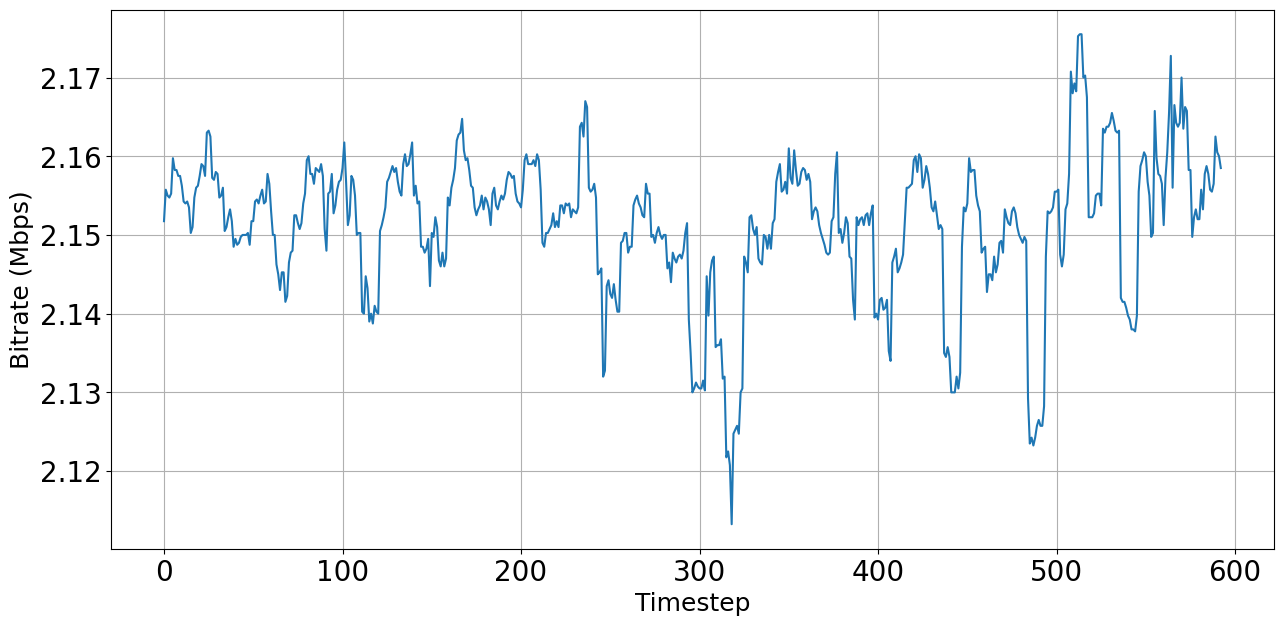

In [157]:

plt.figure(figsize=(15, 7))
plt.plot(kpi_data[kpi_data['slice_id'] == 0]['adjusted_timestep'][10:]-10, kpi_data[kpi_data['slice_id'] == 0]['tx_brate'][10:].rolling(window=10).mean())

plt.grid()
plt.xlabel("Timestep", fontsize=18)
plt.ylabel("Bitrate (Mbps)", fontsize=18)
plt.tick_params(axis='both', labelsize=20)
plt.show()

In [145]:
symbolic_effects

,timestep,slice_id,prb_decision,sched_decision,tx_brate,tx_pckts,dl_buffer,combined_decision
0,2,0,"const(prb, C4)",toWF(sched),"inc(tx_brate, Q4)","inc(tx_pckts, Q4)","const(dl_buffer, Q1)","const(prb, C4) - toWF(sched)"
1,2,1,"const(prb, C1)",toPF(sched),"inc(tx_brate, Q4)","inc(tx_pckts, Q4)","const(dl_buffer, Q1)","const(prb, C1) - toPF(sched)"
2,2,2,"const(prb, C2)",toPF(sched),"inc(tx_brate, Q4)","inc(tx_pckts, Q4)","const(dl_buffer, Q1)","const(prb, C2) - toPF(sched)"
3,3,0,"const(prb, C4)",const(sched),"const(tx_brate, Q4)","const(tx_pckts, Q4)","const(dl_buffer, Q1)","const(prb, C4) - const(sched)"
4,3,1,"const(prb, C1)",const(sched),"inc(tx_brate, Q3)","const(tx_pckts, Q3)","const(dl_buffer, Q1)","const(prb, C1) - const(sched)"
...,...,...,...,...,...,...,...,...
1822,609,1,"const(prb, C1)",const(sched),"inc(tx_brate, Q1)","inc(tx_pckts, Q1)","inc(dl_buffer, Q3)","const(prb, C1) - const(sched)"
1823,609,2,"const(prb, C2)",const(sched),"const(tx_brate, Q3)","dec(tx_pckts, Q2)","const(dl_buffer, Q1)","const(prb, C2) - const(sched)"
1824,610,0,"const(prb, C4)",const(sched),"const(tx_brate, Q4)","const(tx_pckts, Q4)","dec(dl_buffer, Q1)","const(prb, C4) - const(sched)"
1825,610,1,"const(prb, C1)",const(sched),"inc(tx_brate, Q2)","inc(tx_pckts, Q3)","dec(dl_buffer, Q1)","const(prb, C1) - const(sched)"


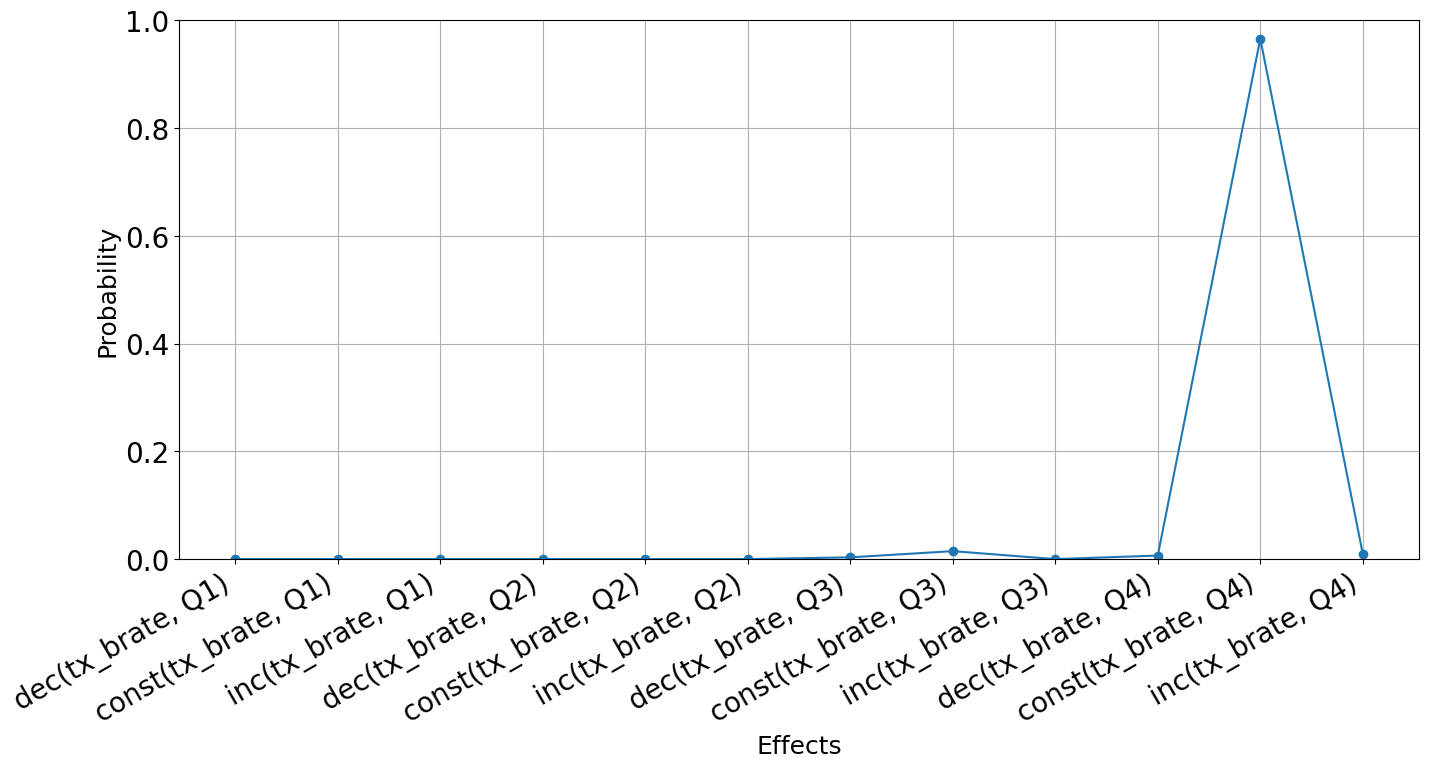

In [158]:
def create_effects_list(kpis=['tx_brate'], changes=['dec', 'const', 'inc']):
    return {
        kpi: [f'{change}({kpi}, Q{quartile})' for quartile in range(1, 5) for change in changes] for kpi in kpis
    }
effects_list = create_effects_list()

plt.figure(figsize=(16, 7))

effect_counts = symbolic_effects[symbolic_effects['slice_id'] == 0]['tx_brate'].value_counts(normalize=True).reindex(effects_list['tx_brate'], fill_value=0).reset_index()
effect_counts.columns = ['effects', 'probability']
plt.plot(effect_counts['effects'], effect_counts['probability'], marker="o")



plt.grid()
plt.ylim(bottom=0, top=1)
plt.xticks(rotation=30, ha='right')
# plt.title("Probability Distribution of Agent's effect on Bitrate of the network", fontsize=16)
plt.xlabel("Effects", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.tick_params(axis='both', labelsize=20)
plt.show()

In [139]:
###################### Load Slice Data
slice_data = symbolic_effects[symbolic_effects['slice_id'] == 0].copy()

###################### Draw Graph
# Load graph and pyvis object plus group community 
G, net = plot_graph_from_data(slice_data, 'combined_decision')
file_name = f"./poster_slice_graph.html"       
# full_file_path = os.path.join(plot_path, file_name)
net.save_graph(file_name)

In [97]:
decision_data['first_element_prb'] = decision_data['prb_decision'].apply(lambda x: x[0] if x else None)
decision_data['first_element_sched'] = decision_data['policy_decision'].apply(lambda x: x[0] if x else None)

In [99]:
decision_data['first_element_sched']

0      1
1      2
2      1
3      2
4      2
      ..
609    0
610    0
611    0
612    0
613    0
Name: first_element_sched, Length: 614, dtype: int64

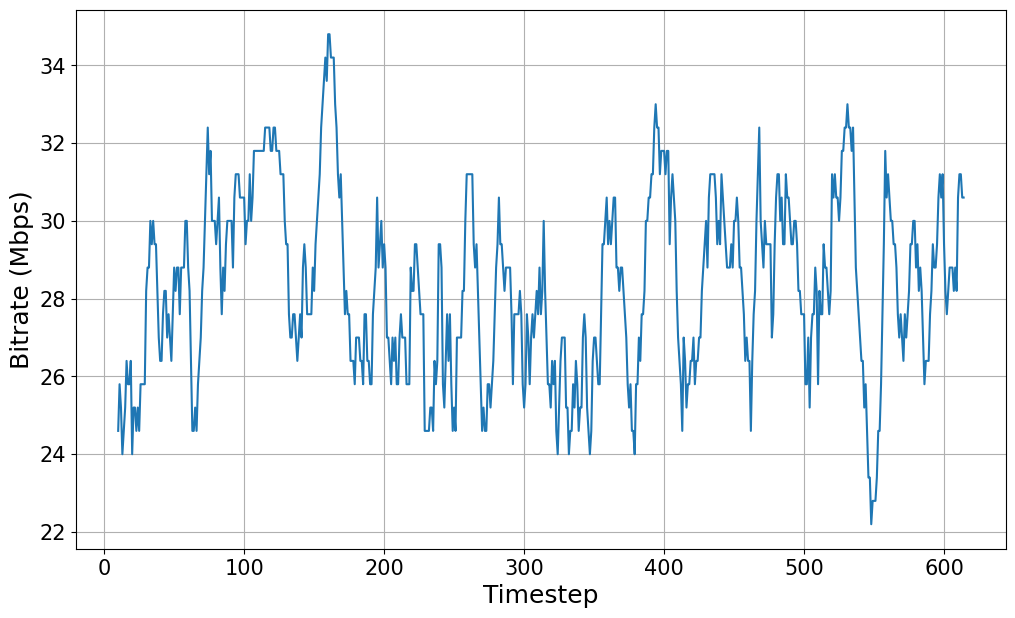

In [90]:
plt.figure(figsize=(12, 7))

plt.plot(decision_data['timestep'], decision_data['first_element'].rolling(window=10).mean())

plt.grid()
plt.xlabel("Timestep", fontsize=18)
plt.ylabel("Bitrate (Mbps)", fontsize=18)
plt.tick_params(axis='both', labelsize=15)
plt.show()

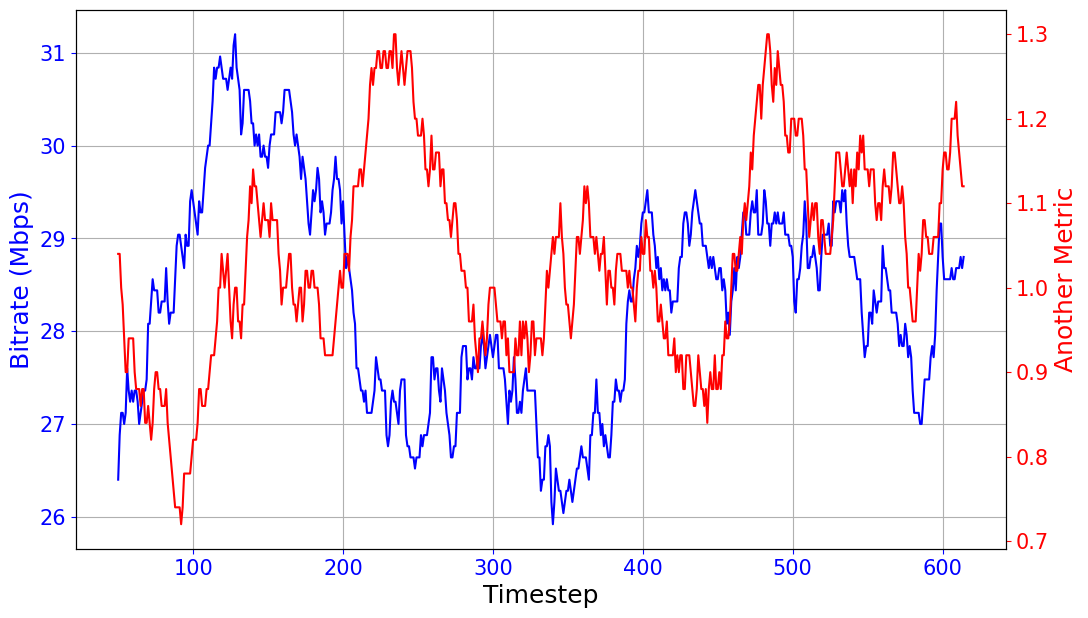

In [102]:
# Create a figure and a set of subplots
plt.figure(figsize=(12, 7))
ax1 = plt.gca()  # Get the current axes instance on the current figure matching the given keyword args, or create one.

# Plot the first data set on ax1
ax1.plot(decision_data['timestep'], decision_data['first_element_prb'].rolling(window=10).mean(), color='b')
ax1.set_xlabel("Timestep", fontsize=18)
ax1.set_ylabel("Bitrate (Mbps)", fontsize=18, color='b')
ax1.tick_params(axis='both', labelsize=15, colors='b')
ax1.grid()

# Create a second axes that shares the same x-axis
ax2 = ax1.twinx()
# Assume 'another_column' is the column you want to plot against the right y-axis
ax2.plot(decision_data['timestep'], decision_data['first_element_sched'], color='r')
ax2.set_ylabel("Another Metric", fontsize=18, color='r')
ax2.tick_params(axis='y', labelsize=15, colors='r')

# Display the plot
plt.show()

In [103]:
for prb, sched in zip(decision_data['first_element_prb'], decision_data['first_element_sched']):
    print(f"[{prb}, {sched}]")

[6, 1]
[24, 2]
[36, 1]
[24, 2]
[24, 2]
[12, 1]
[36, 0]
[30, 1]
[24, 1]
[30, 1]
[18, 2]
[18, 1]
[24, 0]
[30, 0]
[30, 1]
[24, 0]
[30, 0]
[30, 2]
[30, 0]
[6, 1]
[30, 2]
[18, 1]
[18, 0]
[36, 0]
[24, 1]
[36, 2]
[30, 1]
[30, 1]
[30, 2]
[30, 2]
[36, 2]
[18, 1]
[30, 2]
[30, 2]
[30, 1]
[30, 1]
[30, 1]
[18, 1]
[18, 2]
[24, 0]
[36, 2]
[30, 1]
[36, 0]
[30, 0]
[18, 1]
[36, 0]
[24, 0]
[12, 2]
[30, 1]
[36, 1]
[30, 1]
[36, 0]
[36, 0]
[18, 0]
[30, 0]
[36, 1]
[24, 2]
[24, 1]
[30, 1]
[24, 1]
[24, 0]
[18, 0]
[18, 0]
[18, 0]
[36, 0]
[30, 1]
[36, 0]
[30, 0]
[36, 0]
[36, 2]
[30, 1]
[30, 0]
[30, 1]
[30, 2]
[24, 2]
[36, 2]
[18, 0]
[30, 1]
[36, 1]
[30, 2]
[36, 2]
[36, 2]
[12, 0]
[18, 1]
[36, 0]
[30, 0]
[30, 0]
[36, 0]
[36, 2]
[30, 0]
[36, 2]
[24, 0]
[30, 1]
[24, 2]
[36, 1]
[30, 0]
[24, 0]
[36, 2]
[36, 2]
[30, 2]
[24, 1]
[30, 0]
[30, 1]
[36, 2]
[24, 0]
[36, 0]
[36, 2]
[36, 1]
[36, 2]
[30, 1]
[24, 1]
[30, 1]
[30, 0]
[36, 0]
[30, 1]
[36, 2]
[36, 2]
[36, 0]
[30, 2]
[30, 1]
[30, 0]
[30, 1]
[24, 2]
[36, 0]
[30, 0]
[3